# Visualization for the Cross VESRI meeting

Here I am reproducing the rotating 3d globe plot I previously made for the OM4 run with ZB20 vs 'regular' (not currently in this repo, somewhere in `EVENTS/2023_09_18_m2lines_site_visit_2023` on my LEAP hub storage).


## Required installs + functions

In [1]:
# ! pip install -e /home/jovyan/PROJECTS/ocean_emulators

In [1]:
#TODO: Factor these out into a module (WHAT IS THE EASIEST WAY TO DO THAT?) Do I need to build a full blown package?

import os
def check_docker_image(image_tag:str):
    """Assure that the kurrent kernel is running the exact `image_tag` otherwise raise error"""
    spec = os.environ['JUPYTER_IMAGE_SPEC']
    if not spec == image_tag:
        raise ValueError(f"JUPYTER_IMAGE_SPEC environment variable did not match {image_tag=} got {spec}")
    else:
        print(f"Using JUPYTER_IMAGE_SPEC={spec}")

##### viz stuff (should also be factored out)
## camera stuff
def make_points(r,n, xoffset, yoffset, linear, funky, rotation_factor):
    """Helper to make XYZ points"""
    start = (2.55 + +0.25) * np.pi # the camera up gets confused when we are looking straight down. So start at a very slight angle
    rotation = (rotation_factor * np.pi)
    stop = start + rotation
    if linear:
        theta = np.linspace(start, stop, n)
    else:
        theta = np.geomspace(start, stop, n)
    
    if funky:
        # move closer and rotate a bit
        x = np.linspace(0, r/5, n)
        r = np.linspace(r, r*1/2, n)
    else:
        x = np.zeros(n)
    
    y = r * np.cos(theta)
    z = r * np.sin(theta)
    # swap dimensions
    z, x, y = x, y, z
    return np.column_stack((x+xoffset, y+yoffset, z))

def lines_from_points(points):
    """Given an array of points, make a line set"""
    poly = pv.PolyData()
    poly.points = points
    cells = np.full((len(points) - 1, 3), 2, dtype=np.int_)
    cells[:, 1] = np.arange(0, len(points) - 1, dtype=np.int_)
    cells[:, 2] = np.arange(1, len(points), dtype=np.int_)
    poly.lines = cells
    return poly


def orbital_path(r=1e-10,n=100, xoffset=0, yoffset=0, rotation_factor=1, linear=True, funky=False):
    points = make_points(r, n, xoffset, yoffset, linear, funky, rotation_factor)
    line = lines_from_points(points)
    line["scalars"] = np.arange(line.n_points)
    return line

def get_frame(ds, t, subsample, variable, nanmask, x_dim, y_dim, lon_name, lat_name):
    da = ds.isel({'time':t, x_dim:slice(None, None, subsample), y_dim:slice(None, None, subsample)}).drop('time')
    for co in [lon_name, lat_name]:
        da = da.assign_coords({co:da.coords[co].where(nanmask)})
    da = da[variable]
    return da

def make_mesh(da, lon_name, lat_name):
    lon = da[lon_name]
    lat = da[lat_name]
    mesh = gv.Transform.from_2d(lon, lat, data=da.data)
    # # Remove cells from the mesh with NaN values.
    mesh = mesh.threshold()
    return mesh

def update_mesh(plotter, ds, f, subsample, variable, clim, cmap, nanmask, x_dim, y_dim, lon_name, lat_name):
    da = get_frame(ds, f, subsample, variable, nanmask, x_dim, y_dim, lon_name, lat_name)
    mesh = make_mesh(da, lon_name, lat_name)
    # sargs = {
    #     # "title": f"{da.name} / {da.units}",
    #     "height":0.25,
    #     "vertical":True,
    #     "position_x":0.05,
    #     "position_y":0.05
    # }
    actor = plotter.add_mesh(
        mesh,
        show_edges=False,
        show_scalar_bar=False,
        # scalar_bar_args=sargs,
        cmap=cmap,
        clim=clim,
        interpolate_before_map=True ######### 🔥 MIGHT AFFECT PERFORMANCE
    )
    return actor

def make_movie(ds_movie, variable, cmap, clim, filename, preview=False, x_dim='x', y_dim='y', lon_name='lon', lat_name='lat'):

    # some checks
    if any(len(ds_movie[co].dims)!=2 for co in [lon_name, lat_name]):
        raise ValueError(f"Expected longitude and latitude coordinates to be 2 dimensional. Got {[(co, list(ds_movie[co].dims)) for co in [lon_name, lat_name]]}")

    # It seems like some of the internal steps (`make_mesh` and in particular gv.Transform.from_2d(lon, lat, data=da.data) seem to assume that)
    # the dimensions are ordered in a certain way! 
    # TODO: Raise an issue and see if we can fix this upstream
    # for now always transpose here
    other_dims = [dim for dim in list(ds_movie.dims) if dim not in ['time', x_dim, y_dim]] #FIXME (also make time generic?)
    ds_movie = ds_movie.transpose(*['x', 'y', 'time']+other_dims)
    
    nanmask = ~np.isnan(ds_movie.isel(time=0)[variable]).reset_coords(drop=True)
    
    if preview:
        pv.global_theme.trame.interactive_ratio = 0.75 #1 or 2 
        pv.global_theme.trame.still_ratio = 4
        subs = 1
        window_size = None
    else:
        #(does this affect the movie quality?)
        pv.global_theme.trame.interactive_ratio = 5 #1 or 2 (does this affect the movie quality?)
        pv.global_theme.trame.still_ratio = 5
        subs = 1
        window_size = ([3840, 2160]) #4k res
        # window_size = ([1920, 1088]) #HD res
    
    
    p = gv.GeoPlotter(
        window_size= window_size,
        lighting='three lights'
    )
    
    p.add_base_layer(texture=gv.natural_earth_1())
    p.background_color = "black"
    
    # first mesh add
    c = update_mesh(p, ds_movie, 0, subs, variable, clim, cmap, nanmask, x_dim, y_dim, lon_name, lat_name)

    ###### this whole block needs to be provided as an input class that just spits out camera position per frame
    move_fraction = 0.8
    n_time = len(ds_movie.time)
    frames = range(int(n_time*move_fraction))# make this 400
    no_move_frames = range(frames.stop, n_time)
    
    # create a camera path (isnt working because of the crs...
    opath = orbital_path(r=5, n=len(frames), funky=True, rotation_factor=0.9)
    p.camera_position = opath.points[0,:]
    p.camera.focal_point = (0, 0, 0)

    #### up until here

    movie_name = f'{filename}_{variable}.mp4'
    
    if preview:
        #$visualize the camera path
        tube = opath.tube(radius=0.006)
        p.add_mesh(tube, smooth_shading=True)
        p.camera_position = 'xz'
        p.show()
    else:
        p.open_movie(movie_name)
        p.write_frame()  # Write initial
        
        for f in tqdm(frames[1:]):
            # remove previous actor
            p.remove_actor(c)
            # update actor
            c = update_mesh(p, ds_movie, f, subs, variable, clim, cmap, nanmask, x_dim, y_dim, lon_name, lat_name)
            # step camera
            p.camera.position = opath.points[f,:]
            p.camera.focal_point = (0, 0, 0)
            p.write_frame()  # Write this frame
            # p.camera.zoom(z)

        for f_still in tqdm(no_move_frames):
            # remove previous actor
            p.remove_actor(c)
            # update actor
            c = update_mesh(p, ds_movie, f_still, subs, variable, clim, cmap, nanmask, x_dim, y_dim, lon_name, lat_name)
            p.write_frame()  # Write this frame
            
        print(f"Done with {movie_name}")
        # Be sure to close the plotter when finished
        p.close()
        

In [2]:
## bring over code from ocean_emulators because the docker image still needs work to have git (https://github.com/jbusecke/pangeo_pyvista_docker_image/pull/1)
import xarray as xr

def post_processor(ds: xr.Dataset) -> xr.Dataset:
    """Converts the prediction output to an xarray dataset with the same dimensions/variables as input"""
    da = ds["__xarray_dataarray_variable__"]
    n_lev = 19
    variables = ["uo", "vo", "thetao", "so"]
    slices = [slice(i, i + n_lev) for i in range(0, len(variables) * n_lev, n_lev)]
    var_slices = {k: sl for k, sl in zip(variables, slices)}
    variables = {
        k: da.isel(var=sl).rename({"var": "lev"}) for k, sl in var_slices.items()
    }
    variables["zos"] = da.isel(var=-1).squeeze()
    return xr.Dataset(variables)

## Check docker image

The dependencies for this are really gnarly, so always run this with a pre-built image

In [3]:
check_docker_image("quay.io/jbusecke/pangeo_pyvista_docker_image:d6d538dbde81")

Using JUPYTER_IMAGE_SPEC=quay.io/jbusecke/pangeo_pyvista_docker_image:d6d538dbde81


In [4]:
import xarray as xr

import pyvista as pv
pl = pv.Plotter()
print(pl.render_window.ReportCapabilities())

import geovista as gv
import geovista.theme
import pyvista as pv
import numpy as np
from tqdm.auto import tqdm
pv.set_jupyter_backend("server") #https://github.com/pyvista/pyvista/issues/4652
pv.global_theme.trame.server_proxy_enabled = True

OpenGL vendor string:  


## Loading the data

In [5]:
ds_prediction_raw = xr.open_dataset("gs://leap-persistent/sd5313/convnextpredepoch50.zarr", engine='zarr', chunks={})
ds_input = xr.open_dataset("gs://leap-persistent/sd5313/OM4_Horizontal_Regrid_Old.zarr", engine='zarr', chunks={})
# define the 'groundtruth' based on the relevant timesteps
ds_groundtruth = ds_input.isel(time=slice(4141, 4741))

# # quick fix: 
ds_prediction_raw = ds_prediction_raw.assign_coords(time=ds_groundtruth.time)
ds_prediction_raw = ds_prediction_raw.rename({'x':'x_i', 'y':'y_i'}).rename({'x_i':'y', 'y_i':'x'})

ds_prediction = post_processor(ds_prediction_raw)
## TODO: these need to go into the postprocessor!
ds_prediction = ds_prediction.assign_coords(lev=ds_groundtruth.lev, x=ds_groundtruth.x, y=ds_groundtruth.y) # Fixme these are also just counters
#TODO this should be part of the postprocessor
wetmask = ~np.isnan(ds_groundtruth.isel(time=0, lev=0).uo) #assumes that this is the same on all the input (should be tested)
ds_prediction = ds_prediction.where(wetmask)


ds_prediction

# ds_prediction = post_processor(ds_prediction_raw) #FIXME: This should be done before uploading the prediction output.
# # quick fix (coords to lev)
# ds_prediction = ds_prediction.assign_coords(lev=range(len(ds_prediction.lev)), x=ds_input.x, y=ds_input.y)

# # Run the test to make sure the output is formatted correctly
# prediction_data_test(ds_prediction, ds_input)

<xarray.Dataset>
Dimensions:  (time: 600, y: 180, x: 360, lev: 19)
Coordinates:
  * time     (time) object 2014-09-25 12:00:00 ... 2022-12-09 12:00:00
  * lev      (lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    uo       (time, y, x, lev) float64 dask.array<chunksize=(75, 23, 45, 10), meta=np.ndarray>
    vo       (time, y, x, lev) float64 dask.array<chunksize=(75, 23, 45, 1), meta=np.ndarray>
    thetao   (time, y, x, lev) float64 dask.array<chunksize=(75, 23, 45, 2), meta=np.ndarray>
    so       (time, y, x, lev) float64 dask.array<chunksize=(75, 23, 45, 3), meta=np.ndarray>
    zos      (time, y, x) float64 dask.array<chunksize=(75, 23, 45), meta=np.ndarray>

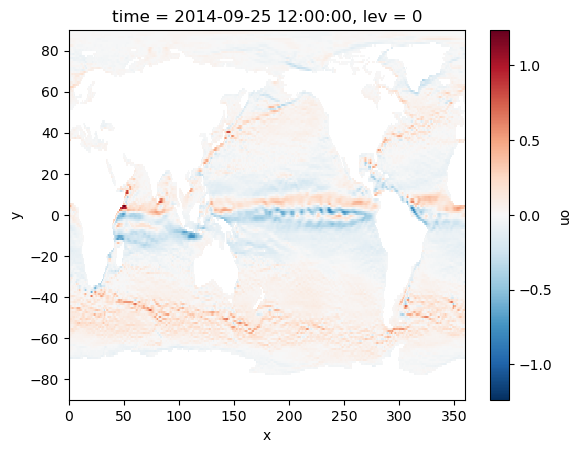

In [6]:
ds_prediction.isel(time=0, lev=0).uo.plot()

>[!WARNING]
>While the docker image builds, lets forge ahead.

In [7]:
def preprocess_movie(ds:xr.Dataset) -> xr.Dataset:
    # patch the 'seam' (TODO Move to the movie functions)
    ds_patch = ds.isel(x=0)
    ds_patch = ds_patch.assign_coords(x=360+ds_patch.x)
    ds = xr.concat([ds, ds_patch], dim='x')
    ds
    ##### just for the movie
    # add log10 of speed
    speed = (ds.uo**2 + ds.vo**2)**0.5
    ds['speed'] = np.log10(speed)
    
    
    # make 2d lon/lat arrays
    #??? Do we actually have lon/lat on the new 'clean' datasets?
    lon,lat = xr.broadcast(ds.x, ds.y)
    ds = ds.assign_coords(lon=lon, lat=lat)
    return ds

# ds_movie.isel(time=0).thetao.plot(x='lon', y='lat')
from dask.diagnostics import ProgressBar

with ProgressBar():
    ds_movie = preprocess_movie(ds_prediction.isel(lev=0)).load()
    ds_movie_depth = preprocess_movie(ds_prediction.isel(lev=5)).load()
    ds_movie_groundtruth = preprocess_movie(ds_groundtruth.isel(lev=0)).load()

[########################################] | 100% Completed | 20.47 s
[########################################] | 100% Completed | 20.55 s
[########################################] | 100% Completed | 84.43 s


In [11]:
cmap_dict={'thetao':'viridis', 'zos':'RdBu', 'speed':'inferno', 'so':'cividis'}
# clim_dict={'tos':[6, 35], 'zos':[-1.5, 1.5], 'speed':[-1.5, 0.5]}
clim_dict={
    'thetao':[0, 30],
    'so':[28, 39],
    'zos':[-1.5, 1.5],
    'speed':[-1.5, 0.5], # note the speed is already converted to log10!
}

v = 'speed'
make_movie(ds_movie_depth, v, cmap_dict[v], clim_dict[v], f"Testing Ocean Emulator", preview=True)

/tmp/ipykernel_3862/3260125627.py:148: UserWarning: Found no coordinate reference system (CRS) attached to mesh.
  p.add_mesh(tube, smooth_shading=True)


Widget(value="<iframe src='/user/jbusecke/proxy/43761/index.html?ui=P_0x7af8842433a0_1&reconnect=auto' style='…

In [10]:
# test smoothness enhancement + different colorscale
cmap_dict={'speed':'inferno'}
clim_dict={
    'speed':[-1.0, 0.7], # note the speed is already converted to log10!
}
for v in ['speed']:
    make_movie(ds_movie_groundtruth, v, cmap_dict[v], clim_dict[v], f"Test_remove_artifacts", preview=False)

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Done with Test_remove_artifacts_speed.mp4


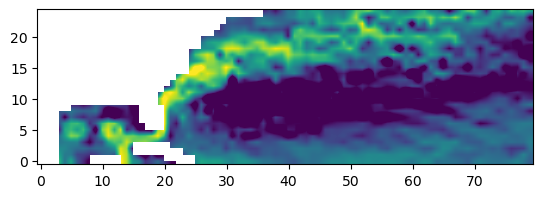

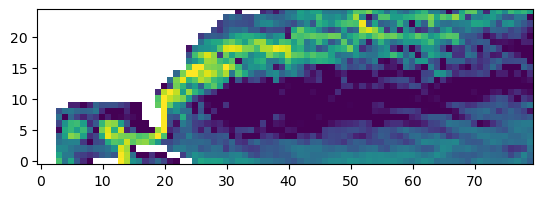

In [35]:
import matplotlib.pyplot as plt
da = ds_movie_groundtruth.speed.isel(time=20).sel(x=slice(260, 340), y=slice(20, 45)).load()
data = da.data
x = da.lon.data
y = da.lat.data
plt.figure()
plt.imshow(data, origin='lower', interpolation='bilinear', vmin=-1.5, vmax=-0.3)
plt.figure()
plt.imshow(data, origin='lower', vmin=-1.5, vmax=-0.3)

In [12]:
# for v in cmap_dict.keys():
    # make_movie(ds_movie, v, cmap_dict[v], clim_dict[v], f"ocean_emulators_OM4_convnextpredepoch50", preview=False)

In [13]:
for v in cmap_dict.keys():
    make_movie(ds_movie_groundtruth, v, cmap_dict[v], clim_dict[v], f"ocean_emulators_OM4_groundtruth", preview=False)

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Done with ocean_emulators_OM4_groundtruth_thetao.mp4


  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Done with ocean_emulators_OM4_groundtruth_zos.mp4


  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Done with ocean_emulators_OM4_groundtruth_speed.mp4


  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Done with ocean_emulators_OM4_groundtruth_so.mp4


In [14]:
for v in cmap_dict.keys():
    make_movie(ds_movie_depth, v, cmap_dict[v], clim_dict[v], f"ocean_emulators_OM4_convnextpredepoch50_depth", preview=False)

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Done with ocean_emulators_OM4_convnextpredepoch50_depth_thetao.mp4


  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Done with ocean_emulators_OM4_convnextpredepoch50_depth_zos.mp4


  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Done with ocean_emulators_OM4_convnextpredepoch50_depth_speed.mp4


  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Done with ocean_emulators_OM4_convnextpredepoch50_depth_so.mp4


ERROR:aiohttp.server:Error handling request
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/aiohttp/web_protocol.py", line 433, in _handle_request
    resp = await request_handler(request)
  File "/opt/conda/lib/python3.10/site-packages/aiohttp/web_app.py", line 504, in _handle
    resp = await handler(request)
  File "/opt/conda/lib/python3.10/site-packages/wslink/backends/aiohttp/__init__.py", line 210, in handleWsRequest
    await current_ws.prepare(request)
  File "/opt/conda/lib/python3.10/site-packages/aiohttp/web_ws.py", line 138, in prepare
    payload_writer = await super().prepare(request)
  File "/opt/conda/lib/python3.10/site-packages/aiohttp/web_response.py", line 421, in prepare
    return await self._start(request)
  File "/opt/conda/lib/python3.10/site-packages/aiohttp/web_response.py", line 429, in _start
    await self._write_headers()
  File "/opt/conda/lib/python3.10/site-packages/aiohttp/web_response.py", line 502, in _write_heade